# HW3: Sankalp Singh CIS 731 ANN
## Problem Statement
### In this assignment, we have experimented with a convolutional neural network implementation on a non-trivial image classification problem. Here, we have implemented a CNN network on a dataset that is available on Kaggle. The dataset represents a Kaggle challenge - 'Dogs vs Cats'. The dataset includes two zip files - train & test. The train archive consists of 25,000 images of dogs and cats. Test archive contains 12,500 images of dogs and cats. We have implemented several CNN models with different parameters and layers. Our models will be solving this binary classification problem - Given an input test image, the CNN model will be predicting if that image belongs to a binary class - either dogs/cats. 

## Dataset

- This dataset can be found on Kaggle - 'Dogs vs Cats'. The dataset includes two zip files - train.zip & test1.zip 

- The train archive consists of 25,000 images of dogs and cats. Test archive contains 12,500 images of dogs and cats.

### Import Libraries

Importing all the required libraries that will help us perform data pre-processing, visualizations, modeling and performance evaluation.

In [1]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, ShuffleSplit, LeaveOneOut
from timeit import default_timer as timer
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
import random
import os, cv2, itertools
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.utils import shuffle

## Dataset Pre-processing

- Firstly, we have defined variables for root directories of the train and test directories

- Secondly, we have defined variables for the input pixels of our image as [64x64x3]

- Thirdly, we have defined variables which we will be using for looping through all the train and test images present at the root directory and storing them in train_images and test_images respectively.

- We have read the images using the OpenCV package from Python

- Finally, we have defined a function which takes up all the images as a list and transform the images in the format required as an input for a CNN model

- We have used the prep_data function to prepare our training and testing data in the format required by CNN

In [2]:
# declaring variables for root directory information of train and test set
TRAIN_DIR = './train/'
TEST_DIR = './test1/'

# declaring variable for the input pixels as 64x64x3 
ROWS = 64
COLS = 64
CHANNELS = 3

In [3]:
# storing all the train and test images as a list from the root directories 
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [4]:
# function to read images from the above list as images using OpenCV
def read_image(file_path):
  #print(file_path)
  img = cv2.imread(file_path, cv2.IMREAD_COLOR)
  #print(img)
  return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

In [5]:
# function to transform the images from a list to the format required as input for the CNN model  
def prep_data(images):
  m = len(images)
  n_x = ROWS*COLS*CHANNELS
  
  X = np.ndarray((m,ROWS,COLS,CHANNELS), dtype=np.uint8)
  y = np.zeros((m,1))
  
  
  for i,image_file in enumerate(images) :
    image = read_image(image_file)
    X[i,:] = np.squeeze(image.reshape((ROWS, COLS, CHANNELS)))
    if 'dog' in image_file.lower() :
      y[i,0] = 1
    elif 'cat' in image_file.lower() :
      y[i,0] = 0
    else : # for test data
      y[i,0] = image_file.split('/')[-1].split('.')[0]
      
    
    
  return X,y

In [6]:
# Preparing the train and test data for input to the CNN model
X_train, y_train = prep_data(train_images)
X_test, test_idx = prep_data(test_images)

In [7]:
# printing the shape of the final transformed Train and Test data for CNN model
print("Train shape: {}".format(X_train.shape))
print("Test shape: {}".format(X_test.shape))

Train shape: (25000, 64, 64, 3)
Test shape: (12500, 64, 64, 3)


## Modeling - Convolutional Neural Network

- Firsly, we have shuffled the train set to generate a shuffled variable X=containing all the train images and y=containing all the train image labels

- Secondly, we have performed the train-validation split 80-20%

- Thirdly, we have converted the train and validation image labels to one-hot encoding vectors

- We have defined the two classes that our models will be predicting: 0-Cats & 1-Dogs

- Finally, we have normalized the train and validation images

- After this, we have build 4 models using CNN networks


In [8]:
# shuffling the train images and labels
X, y = shuffle(X_train, y_train)

In [9]:
# print train images shape
X.shape

(25000, 64, 64, 3)

In [10]:
# print train image labels shape
y.shape

(25000, 1)

In [11]:
# Train-validation split 80-20%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

# print train & validation images and labels shapes
print("Training images shape: {}".format(X_train.shape))
print("Training labels shape: {}".format(y_train.shape))
print("Validation images shape: {}".format(X_val.shape))
print("Validation labels shape: {}".format(y_val.shape))

Training images shape: (20000, 64, 64, 3)
Training labels shape: (20000, 1)
Validation images shape: (5000, 64, 64, 3)
Validation labels shape: (5000, 1)


In [12]:
# One-hot encoding training image labels
y_train_one_hot = to_categorical(y_train)

# One-hot encoding validation image labels
y_val_one_hot = to_categorical(y_val)


In [13]:
# defining output classes for our binary prediction
classes = {0: 'cat',
          1: 'dog'}

### Viusalize the train images

In [34]:
# function to visualize the dataset
def show_images(X, y, idx) :
  image = X[idx]
  
  plt.figure(figsize=(4,2))
  plt.imshow(image)
  plt.title("This is a {}".format(classes[y[idx,0]]))
  plt.show()

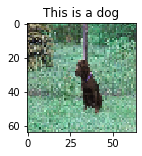

In [35]:
# printing image at train set index 0
show_images(X_train, y_train, 0)

In [14]:
# Normalizing the train and validation images
X_train_norm = X_train / 255
X_val_norm = X_val / 255

### CNN model1

- Initially we have set the seed so that model performance does not vary with each run

- For this model, we have stacked 4 convolution layers along with 4 max pooling layers followed by 1 flatten layer followed by 1 fully connected layer and finally a sigmoid output layer
    
- 1st conv layer consists of the first hidden layer with 32 filters, each with size 3x3 and input shape as 64x64x3 followed by a relu activation function and a maxPooling layer

- 2nd conv layer consists of the a hidden layer with 32 filters, each with size 3x3 & a relu activation function and a maxPooling layer. We have added the regularization dropout parameter as well as 0.6

- 3rd conv layer consists of the a hidden layer with 64 filters, each with size 3x3 & a relu activation function and a maxPooling layer.

- 4th conv layer consists of the a hidden layer with 64 filters, each with size 3x3 & a relu activation function and a maxPooling layer.

- Next layer consists of a flatten layer with a dropout paramter as 0.6

- Next layer is a fully connected layer with relu as the activation function

- Final layer is a sigmoid layer which will classify image as a 0/1

-  We have used optimizer='adam' and loss function='categorical_crossentropy'

- Hyperparameters: 
    
    epochs=10, 
    
    batch_size=64




                                

In [15]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)


# building model1 for CNN
model1 = Sequential()

model1.add(Conv2D(32, (3,3), input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.6))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

model1.add(Flatten())
model1.add(Dropout(0.6))

model1.add(Dense(units=120, activation='relu'))
model1.add(Dense(units=2, activation='sigmoid'))

# compliling the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# printing model summary
model1.summary()

# fitting the model
history1 = model1.fit(X_train_norm, y_train_one_hot, validation_data=(X_val_norm, y_val_one_hot), epochs=10, batch_size = 64)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

### Results for CNN model1
- CNN model1 achieved a best validation MSE of 0.42 after 10 epochs

- CNN model1 achieved a best validation accuracy of 81.22% after 10 epochs

In [16]:
# Calculating the final train mse
model1_train_error = history1.history['loss']
print('Final Train MSE for CNN model1:', model1_train_error[-1] )

# Calculating the final validation mse
model1_validation_error = history1.history['val_loss']
print('Final Validation MSE for CNN model1:', model1_validation_error[-1] )

# Calculating the final train accuracy
model1_train_acc = history1.history['accuracy']
print('Final Train Accuracy for CNN model1:', model1_train_acc[-1] )

# Calculating the final validation accuracy
model1_validation_acc = history1.history['val_accuracy']
print('Final Validation Accuracy for CNN model1:', model1_validation_acc[-1] )

Final Train MSE for CNN model1: 0.46491700410842896
Final Validation MSE for CNN model1: 0.4245340824127197
Final Train Accuracy for CNN model1: 0.7777500152587891
Final Validation Accuracy for CNN model1: 0.8122000098228455


### Plotting MSE vs Number of weight updates for CNN model1

- From the below graph we can infer that initially validation error is lower than train error. Then after almost 2 epochs, validation error starts fluctuating abve and below train error

- We can see that the validation error is below the training error towards the end. This means that our model is underfitting

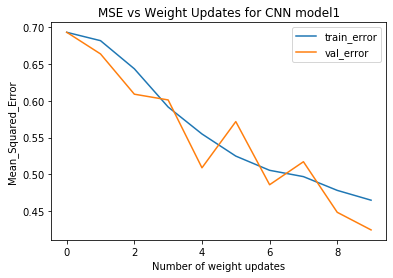

In [17]:
# Plotting MSE vs Weight updates
plt.plot(model1_train_error)
plt.plot(model1_validation_error)
plt.title('MSE vs Weight Updates for CNN model1')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

### Plotting Accuracy vs Number of weight updates for CNN model1

- From the below graph we can infer that initially validation accuracy is higher than train accuracy. Then after almost 2 epochs, validation accuracy starts to fluctuate

- We can see that the validation accuracy is higher than the training accuracy towards the end. This means that our model is underfitting

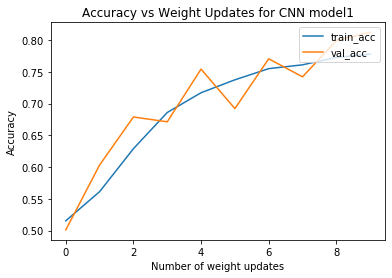

In [18]:
# Plotting Accuracy vs Weight updates
plt.plot(model1_train_acc)
plt.plot(model1_validation_acc)
plt.title('Accuracy vs Weight Updates for CNN model1')
plt.ylabel('Accuracy')
plt.xlabel('Number of weight updates')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

### CNN model2

- Initially we have set the seed so that model performance does not vary with each run

- For this model, we have stacked 4 convolution layers along with 4 max pooling layers followed by 1 flatten layer followed by 1 fully connected layer and finally a sigmoid output layer
    
- 1st conv layer consists of the first hidden layer with 32 filters, each with size 3x3 and input shape as 64x64x3 followed by a relu activation function and a maxPooling layer

- 2nd conv layer consists of the a hidden layer with 64 filters, each with size 3x3 & a relu activation function and a maxPooling layer.

- 3rd conv layer consists of the a hidden layer with 128 filters, each with size 3x3 & a relu activation function and a maxPooling layer.

- 4th conv layer consists of the a hidden layer with 256 filters, each with size 3x3 & a relu activation function and a maxPooling layer.

- Next layer consists of a flatten layer

- Next layer is a fully connected layer with relu as the activation function

- Final layer is a sigmoid layer which will classify image as a 0/1

-  We have used optimizer='adam' and loss function='categorical_crossentropy'

- Hyperparameters: 

    epochs=10, 
    
    batch_size=64



In [19]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)

# building CNN model2
model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))

model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))


model2.add(Conv2D(128, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))

model2.add(Conv2D(256, (3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))

model2.add(Flatten())


model2.add(Dense(units=120, activation='relu'))
model2.add(Dense(units=2, activation='sigmoid'))

# compiling the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

# fitting the model
history2 = model2.fit(X_train_norm, y_train_one_hot, validation_data=(X_val_norm, y_val_one_hot), epochs=10, batch_size = 64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)        

### Results for CNN model2
- CNN model2 achieved a best validation MSE of 0.50 after 10 epochs

- CNN model2 achieved a best validation accuracy of 84.60% after 10 epochs

In [20]:
# Calculating the final train mse
model2_train_error = history2.history['loss']
print('Final Train MSE for CNN model2:', model2_train_error[-1] )

# Calculating the final validation mse
model2_validation_error = history2.history['val_loss']
print('Final Validation MSE for CNN model2:', model2_validation_error[-1] )

# Calculating the final train accuracy
model2_train_acc = history2.history['accuracy']
print('Final Train Accuracy for CNN model2:', model2_train_acc[-1] )

# Calculating the final validation accuracy
model2_validation_acc = history2.history['val_accuracy']
print('Final Validation Accuracy for CNN model2:', model2_validation_acc[-1] )

Final Train MSE for CNN model2: 0.0948745459318161
Final Validation MSE for CNN model2: 0.5034459829330444
Final Train Accuracy for CNN model2: 0.9636499881744385
Final Validation Accuracy for CNN model2: 0.8460000157356262


### Plotting MSE vs Number of weight updates for CNN model2

- From the below graph we can infer that initially validation error is lower than train error. Then after almost 2 epochs both of the errors converge and then validation error becomes higher than the train error

- We can see that the validation error is higher than the training error. This means that our model is overfitting

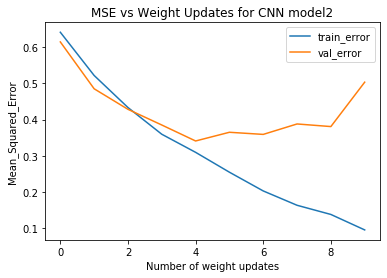

In [21]:
# Plotting MSE vs Weight updates
plt.plot(model2_train_error)
plt.plot(model2_validation_error)
plt.title('MSE vs Weight Updates for CNN model2')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

### Plotting Accuracy vs Number of weight updates for CNN model2

- From the below graph we can infer that initially validation accuracy is higher than train accuracy. Then after almost 3 epochs both of the accuracy converge. Then validation accuracy becomes lower than train accuracy

- We can see that the validation accuracy is lower than the training accuracy. This means that our model is overfitting

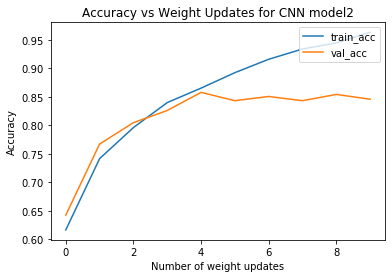

In [22]:
# Plotting Accuracy vs Weight updates
plt.plot(model2_train_acc)
plt.plot(model2_validation_acc)
plt.title('Accuracy vs Weight Updates for CNN model2')
plt.ylabel('Accuracy')
plt.xlabel('Number of weight updates')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

### CNN model3

- Initially we have set the seed so that model performance does not vary with each run

- For this model, we have stacked 4 convolution layers along with 4 max pooling layers followed by 1 flatten layer followed by 1 fully connected layer and finally a sigmoid output layer

- 1st conv layer consists of the first hidden layer with 32 filters, each with size 3x3 and input shape as 64x64x3 followed by a relu activation function and a maxPooling layer

- 2nd conv layer consists of the a hidden layer with 64 filters, each with size 3x3 & a relu activation function and a maxPooling layer. We have added a 'dropout'=0.3

- 3rd conv layer consists of the a hidden layer with 128 filters, each with size 3x3 & a relu activation function and a maxPooling layer. We have added a 'dropout'=0.3 regularization parameter

- 4th conv layer consists of the a hidden layer with 256 filters, each with size 3x3 & a relu activation function and a maxPooling layer.

- Next layer consists of a flatten layer with a 'dropout'=0.3

- Next layer is a fully connected layer with relu as the activation function

- Final layer is a sigmoid layer which will classify image as a 0/1

- We have used optimizer='adam' and loss function='categorical_crossentropy'

- Hyperparameters:

    epochs=10,

    batch_size=64

In [23]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)


# building CNN model3
model3 = Sequential()

model3.add(Conv2D(32, (3,3), input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))

model3.add(Conv2D(64, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(128, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))

model3.add(Conv2D(256, (3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))

model3.add(Flatten())
model3.add(Dropout(0.3))

model3.add(Dense(units=120, activation='relu'))
model3.add(Dense(units=2, activation='sigmoid'))

# compiling the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

# fitting the model
history3 = model3.fit(X_train_norm, y_train_one_hot, validation_data=(X_val_norm, y_val_one_hot), epochs=10, batch_size = 64)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 128)        

### Results for CNN model3
- CNN model3 achieved a best validation MSE of 0.32 after 10 epochs

- CNN model3 achieved a best validation accuracy of 86.08% after 10 epochs

In [24]:
# Calculating the final train mse
model3_train_error = history3.history['loss']
print('Final Train MSE for CNN model3:', model3_train_error[-1] )

# Calculating the final validation mse
model3_validation_error = history3.history['val_loss']
print('Final Validation MSE for CNN model3:', model3_validation_error[-1] )

# Calculating the final train accuracy
model3_train_acc = history3.history['accuracy']
print('Final Train Accuracy for CNN model3:', model3_train_acc[-1] )

# Calculating the final validation accuracy
model3_validation_acc = history3.history['val_accuracy']
print('Final Validation Accuracy for CNN model3:', model3_validation_acc[-1] )

Final Train MSE for CNN model3: 0.24532346427440643
Final Validation MSE for CNN model3: 0.32015350461006165
Final Train Accuracy for CNN model3: 0.8946499824523926
Final Validation Accuracy for CNN model3: 0.86080002784729


### Plotting MSE vs Number of weight updates for CNN model3

- From the below graph we can infer that initially validation error is lower than train error. Then after almost 2 epochs, validation error starts going up and down

- We can see that the validation error is higher than the training error towards the end. This means that our model is overfitting

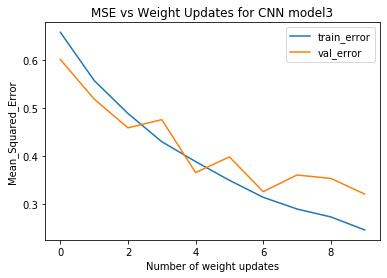

In [25]:
# Plotting MSE vs Weight updates
plt.plot(model3_train_error)
plt.plot(model3_validation_error)
plt.title('MSE vs Weight Updates for CNN model3')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

### Plotting Accuracy vs Number of weight updates for CNN model3

- From the below graph we can infer that initially validation accuracy is higher than train accuracy. Then after almost 2 epochs, validation accuracy starts flickering.

- We can see that the validation accuracy is lower than the training accuracy towards the end. This means that our model is overfitting

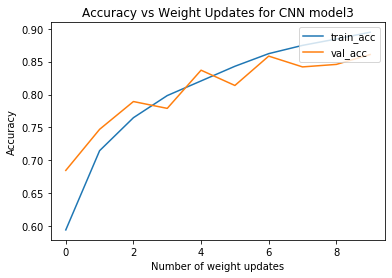

In [26]:
# Plotting Accuracy vs Weight updates
plt.plot(model3_train_acc)
plt.plot(model3_validation_acc)
plt.title('Accuracy vs Weight Updates for CNN model3')
plt.ylabel('Accuracy')
plt.xlabel('Number of weight updates')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

### CNN model4
- Initially we have set the seed so that model performance does not vary with each run

- For this model, we have stacked 5 convolution layers along with 4 max pooling layers followed by 1 flatten layer followed by 1 fully connected layer and finally a sigmoid output layer

- 1st conv layer consists of the first hidden layer with 32 filters, each with size 3x3 and input shape as 64x64x3 followed by a relu activation function and a maxPooling layer

- 2nd conv layer consists of the a hidden layer with 64 filters, each with size 3x3 & a relu activation function and a maxPooling layer. We have added 'dropout'=0.4

- 3rd conv layer consists of the a hidden layer with 128 filters, each with size 3x3 & a relu activation function and a maxPooling layer. We have added a 'dropout'=0.4 regularization parameter

- 4th conv layer consists of the a hidden layer with 256 filters, each with size 3x3 & a relu activation function and a maxPooling layer. We have added a 'dropout'=0.4 regularization parameter

- 5th conv layer consists of the a hidden layer with 512 filters, each with size 1x1 & a relu activation function

- Next layer consists of a flatten layer with a 'dropout'=0.3

- Next layer is a fully connected layer with relu as the activation function

- Final layer is a sigmoid layer which will classify image as a 0/1

- We have used optimizer='adam' and loss function='categorical_crossentropy'

- Hyperparameters:

    epochs=10,

    batch_size=64

In [27]:
# Set the seed
np.random.seed(12345)
tf.random.set_seed(12345)


# building CNN model4
model4 = Sequential()

model4.add(Conv2D(32, (3,3), input_shape=(ROWS, COLS, CHANNELS), activation='relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))

model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(Dropout(0.4))

model4.add(Conv2D(128, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(Dropout(0.4))

model4.add(Conv2D(256, (3,3), activation='relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
model4.add(Dropout(0.4))

model4.add(Conv2D(512, (1,1), activation='relu'))


model4.add(Flatten())
model4.add(Dropout(0.4))

model4.add(Dense(units=120, activation='relu'))
model4.add(Dense(units=2, activation='sigmoid'))

# compiling the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

# fitting the model
history4 = model4.fit(X_train_norm, y_train_one_hot, validation_data=(X_val_norm, y_val_one_hot), epochs=10, batch_size = 64)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 128)        

### Results for CNN model4
- CNN model4 achieved a best validation MSE of 0.34 after 10 epochs

- CNN model4 achieved a best validation accuracy of 84.56% after 10 epochs

In [28]:
# Calculating the final train mse
model4_train_error = history4.history['loss']
print('Final Train MSE for CNN model4:', model4_train_error[-1] )

# Calculating the final validation mse
model4_validation_error = history4.history['val_loss']
print('Final Validation MSE for CNN model4:', model4_validation_error[-1] )

# Calculating the final train accuracy
model4_train_acc = history4.history['accuracy']
print('Final Train Accuracy for CNN model4:', model4_train_acc[-1] )

# Calculating the final validation accuracy
model4_validation_acc = history4.history['val_accuracy']
print('Final Validation Accuracy for CNN model4:', model4_validation_acc[-1] )

Final Train MSE for CNN model4: 0.33041808009147644
Final Validation MSE for CNN model4: 0.3424719572067261
Final Train Accuracy for CNN model4: 0.8560500144958496
Final Validation Accuracy for CNN model4: 0.8456000089645386


### Plotting MSE vs Number of weight updates for CNN model4

- From the below graph we can infer that initially validation error is lower than train error. Then after almost 3 epochs both of the errors converge and then validation error keeps on increasing and decreasing with respect to the train error

- We can see that the validation error is higher than the training error towards the end. This means that our model is overfitting

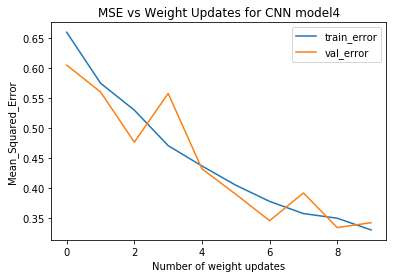

In [29]:
# Plotting MSE vs Weight updates
plt.plot(model4_train_error)
plt.plot(model4_validation_error)
plt.title('MSE vs Weight Updates for CNN model4')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['train_error', 'val_error'], loc='upper right')
plt.show()

### Plotting Accuracy vs Number of weight updates for CNN model4

- From the below graph we can infer that initially validation accuracy is higher than train accuracy. Then after almost 2 epochs, both of the accuracy converge. Then validation accuracy keeps on fluctuating with respect to train accuracy

- We can see that the validation accuracy is lower than the training accuracy towards the end. This means that our model is overfitting

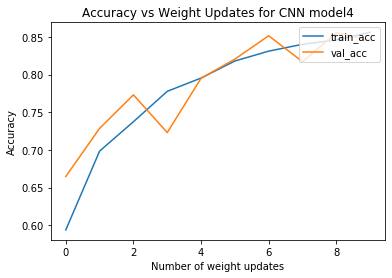

In [30]:
# Plotting Accuracy vs Weight updates
plt.plot(model4_train_acc)
plt.plot(model4_validation_acc)
plt.title('Accuracy vs Weight Updates for CNN model4')
plt.ylabel('Accuracy')
plt.xlabel('Number of weight updates')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

## Model Comparison

- Below we have plotted a graph to compare the validation errors for all 4 models

- We have also plotted a graph to compare the validation accuracy for all 4 models

- Out of the four models, we can see that CNN model3 and CNN model4, both perform very similar in terms of validation error and accuracy and they also outperform other 2 models

- CNN model3 performs slightly better than CNN model4 in terms of validation accuracy and error. This is the reason, we will be evaluating the test data set using the CNN model3

### Plotting validation MSE of all the models vs the Number of weight updates

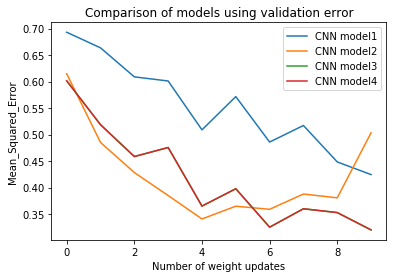

In [31]:
# Plotting validation MSE of all the models vs the Number of weight updates
plt.plot(model1_validation_error)
plt.plot(model2_validation_error)
plt.plot(model3_validation_error)
plt.plot(model3_validation_error)
plt.title('Comparison of models using validation error')
plt.ylabel('Mean_Squared_Error')
plt.xlabel('Number of weight updates')
plt.legend(['CNN model1', 'CNN model2', 'CNN model3', 'CNN model4'], loc='upper right')
plt.show()

### Plotting validation Accuracy of all the models vs the Number of weight updates

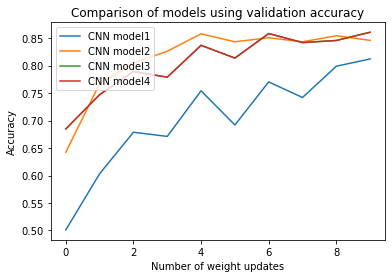

In [44]:
# Plotting validation Accuracy of all the models vs the Number of weight updates
plt.plot(model1_validation_acc)
plt.plot(model2_validation_acc)
plt.plot(model3_validation_acc)
plt.plot(model3_validation_acc)
plt.title('Comparison of models using validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of weight updates')
plt.legend(['CNN model1', 'CNN model2', 'CNN model3', 'CNN model4'], loc='upper left')
plt.show()

## Evaluation on Test Set using Best Model

### Predicting using CNN model3 on a few images from the train set

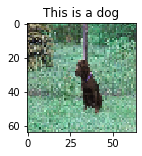

Our Model Prediction(0-cat/1-dog): [1]


In [36]:
# Predicting on train set
image = X_train[0]
test_pred = model3.predict_classes(image.reshape(1, 64, 64, 3))

show_images(X_train, y_train,0)

print("Our Model Prediction(0-cat/1-dog): {}".format(test_pred))

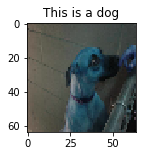

Our Model Prediction(0-cat/1-dog): [1]


In [38]:
# Predicting on train set
image = X_train[100]
test_pred = model3.predict_classes(image.reshape(1, 64, 64, 3))

show_images(X_train, y_train,100)

print("Our Model Prediction(0-cat/1-dog): {}".format(test_pred))

### Predicting using CNN model3 on the test data set

- Here, we have defined a function for displaying the predictions made by our model in a more understandable way

- Then we have used the prep_data function to transform test images in a way that can be inputted to the CNN model

- Finally, we have used the best model - CNN model3 to predict the labels on any 10 random images from the test data set

In [39]:
# function to predict on test data set

def show_image_prediction(X, idx, model) :
  image = X[idx].reshape(1,64,64,3)
  image_class = classes[model.predict_classes(image).item()]
  image = image.reshape((ROWS, COLS, CHANNELS))
  plt.figure(figsize = (4,2))
  plt.imshow(image)
  plt.title("Test {} : Model Predicts this as a {}".format(idx, image_class))
  plt.show()

In [40]:
# transform test data images using prep_data function
X_test, test_idx = prep_data(test_images)

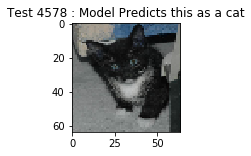

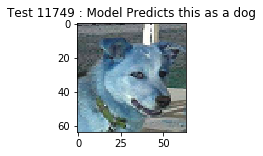

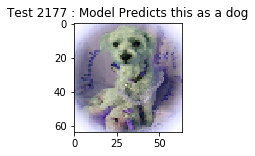

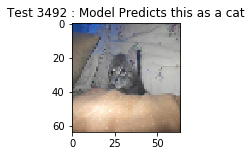

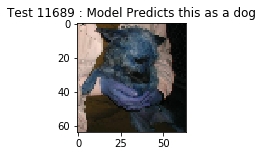

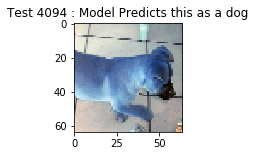

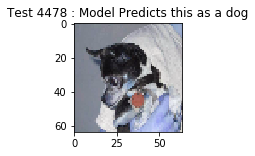

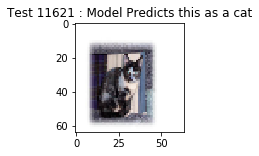

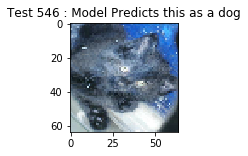

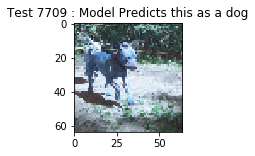

In [41]:
# predicting labels for 10 random images using our best model
X_test_cnn, test_idx = X_test, test_idx

for i in np.random.randint(0, len(X_test_cnn), 10) :
  show_image_prediction(X_test_cnn, i, model3)

## Conclusion: Results & Observations

- According to our results obtained for each of the four CNN models, we can conclude that CNN model3 performed the best among all the models with respect to the validation error and accuracy

- Our best performing model CNN model3 had: stacked 4 convolution layers along with 4 max pooling layers followed by 1 flatten layer followed by 1 fully connected layer and finally a sigmoid output layer

- Our model is able to predict label for images with a training accuracy of 89.46% and a validation accuracy of 86.08%

- Our model is also performing very well on the unseen data as can be seen from the above results on the test set

-  We can try to further increase our model's accuracy by experimenting some more hyperparameter tuning. We were not able to increase the epochs to a large number because of lack of computing power. We might be able to achieve more validation accuracy if we increase the epoch hyperparameter

## Model Summary

In [42]:
# summarizing validation errors, accuracy, layers and epochs for each model
summary_validation_accuracy = [model1_validation_acc[-1], model2_validation_acc[-1], model3_validation_acc[-1], model4_validation_acc[-1]]
summary_validation_mse = [model1_validation_error[-1], model2_validation_error[-1], model3_validation_error[-1], model4_validation_error[-1]]
layers = ['4 CNN & 4 Maxpool', '4 CNN & 4 Maxpool', '4 CNN & 4 Maxpool', '5 CNN & 4 Maxpool']
epochs = ['10', '10', '10', '10']

model_summary = pd.DataFrame({"Model":["CNN model1","CNN model2","CNN model3", "CNN model4"], "Lowest validation MSE Obtained":summary_validation_mse,
                            "Highest validation accuracy obtained":summary_validation_accuracy, "Layers": layers,
                              "Epochs": epochs
                                               })

In [43]:
# print model summary
model_summary

,Model,Lowest validation MSE Obtained,Highest validation accuracy obtained,Layers,Epochs
0,CNN model1,0.424534,0.8122,4 CNN & 4 Maxpool,10
1,CNN model2,0.503446,0.8460,4 CNN & 4 Maxpool,10
2,CNN model3,0.320154,0.8608,4 CNN & 4 Maxpool,10
3,CNN model4,0.342472,0.8456,5 CNN & 4 Maxpool,10


## References

- Dataset: https://www.kaggle.com/c/dogs-vs-cats

- Understanding more about the challenge: https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-2-e9ee4967b9

- Understanding more on CNN: https://medium.com/swlh/a-simple-convolutional-neural-network-summary-for-binary-image-classification-with-keras-d58caf2f84a4

- https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8

- https://medium.com/@manasnarkar/image-classification-with-convolution-neural-networks-cnn-with-keras-dbd71c05ed2a

- https://medium.com/nybles/create-your-first-image-recognition-classifier-using-cnn-keras-and-tensorflow-backend-6eaab98d14dd